In [1]:
!pip install torch torchvision opencv-python matplotlib


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt


In [3]:
transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.Grayscale(),
    transforms.ToTensor()
])

def load_image(path):
    img = Image.open(path)
    return transform(img).unsqueeze(0)


In [10]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(32, 64, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

       
        self._feature_size = self._get_feature_size()

        self.fc = nn.Sequential(
            nn.Linear(self._feature_size, 256),
            nn.ReLU(),
            nn.Linear(256, 128)
        )

    def _get_feature_size(self):
        with torch.no_grad():
            x = torch.zeros(1, 1, 100, 100)  # dummy input
            x = self.cnn(x)
            return x.view(1, -1).size(1)

    def forward_once(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    def forward(self, img1, img2):
        out1 = self.forward_once(img1)
        out2 = self.forward_once(img2)
        return out1, out2


In [11]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=2.0):
        super().__init__()
        self.margin = margin

    def forward(self, out1, out2, label):
        dist = torch.nn.functional.pairwise_distance(out1, out2)
        loss = torch.mean(
            (1 - label) * torch.pow(dist, 2) +
            label * torch.pow(torch.clamp(self.margin - dist, min=0.0), 2)
        )
        return loss


In [20]:
base_img = load_image("img/img1.jpg")
rotated_img = load_image("img/img1_rotated.jpg")   # same image, different orientation
different_img = load_image("img/img4.jpg")


In [21]:
model = SiameseNetwork()
criterion = ContrastiveLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Labels: 0 = same, 1 = different
pairs = [
    (base_img, rotated_img, torch.tensor([0.], dtype=torch.float32)),
    (base_img, different_img, torch.tensor([1.], dtype=torch.float32))
]

for epoch in range(50):
    total_loss = 0
    for img1, img2, label in pairs:
        optimizer.zero_grad()
        out1, out2 = model(img1, img2)
        loss = criterion(out1, out2, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss:.4f}")


Epoch 0, Loss: 3.4339
Epoch 10, Loss: 0.0000
Epoch 20, Loss: 0.0000
Epoch 30, Loss: 0.0000
Epoch 40, Loss: 0.0000


In [22]:
def predict(img1, img2, threshold=1.0):
    model.eval()
    with torch.no_grad():
        out1, out2 = model(img1, img2)
        dist = torch.nn.functional.pairwise_distance(out1, out2)
        return dist.item(), "MATCH" if dist < threshold else "NOT MATCH"


In [23]:
dist1, res1 = predict(base_img, rotated_img)
dist2, res2 = predict(base_img, different_img)

print("Base vs Rotated Image:", res1, " Distance:", dist1)
print("Base vs Different Image:", res2, " Distance:", dist2)


Base vs Rotated Image: MATCH  Distance: 1.131371027440764e-05
Base vs Different Image: NOT MATCH  Distance: 90.59475708007812


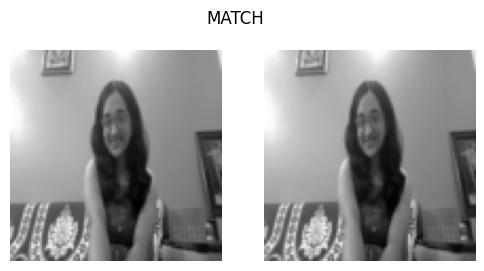

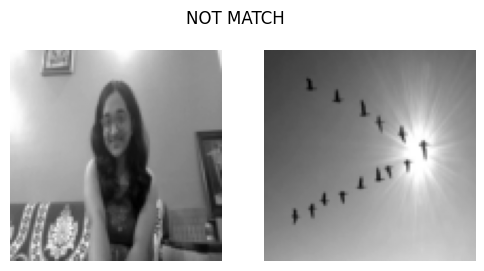

In [24]:
def show(img1, img2, title):
    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1)
    plt.imshow(img1.squeeze(), cmap='gray')
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(img2.squeeze(), cmap='gray')
    plt.axis('off')
    plt.suptitle(title)
    plt.show()

show(base_img, rotated_img, "MATCH")
show(base_img, different_img, "NOT MATCH")
